# Environment Wrapper for Farm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from mcts import MCTS
from agents import * 
import farmgame  # Ensure the farmgame module is imported
from farmgame import *
import statsmodels.api as sm

# Define the FarmEnv class
# class FarmEnv:
#     def __init__(self, farm: Farm, reward_function=None):
#         self.game = farm  # Accept a Farm instance directly
#         self.done = False
#         self.reward_function = reward_function or self.default_reward

#     def reset(self):
#         self.game = configure_game()  # Reset the game
#         self.done = False
#         return self.get_state()

#     def step(self, action):
#         current_player = self.game.whose_turn()["name"]
#         self.game = self.game.take_action(action, inplace=True)  # Apply action
#         reward = self.reward_function(self.game, current_player)  # Calculate reward
#         self.done = self.game.is_done()  # Check if game is done
#         new_state = self.get_state()  # Get the updated state
#         return new_state, reward, self.done, {}  # Return updated state

#     def get_state(self):
#         return self.map

#     def render(self):
#         self.game.print_farm()

#     def default_reward(self, game, player):
#         return game.playersDict[player]["score"]

# Training

In [113]:
state.redplayer['score']

1

In [ ]:
#score used throughout, reward used at end?

In [121]:
len(state.redplayer['backpack']['contents'])

[]

In [123]:
class QLearningAgent:
    def __init__(self, learning_rate, discount_factor, epsilon, seed=None):
        self.q_table = {}  # Dictionary to store Q-values
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon

        # Random seed for reproducibility (optional)
        self.seed = seed or random.randint(0, 1e6)
        random.seed(self.seed)

        self.current_state = None  # Track the latest full state

    def update(self, state):
        self.current_state = state  # Keep the full state object

    def get_state_representation(self, state):
        """
        Convert the state into a hashable representation for the Q-table.
        Assuming 'state' is an object with properties that can be converted to hashable types.
        """
        # Example: Convert agent positions and other attributes to tuples
        agents = tuple((player['loc']['x'], player['loc']['y'], player['name']) for player in [state.redplayer, state.purpleplayer])
        energy_levels =tuple((player['energy']) for player in [state.redplayer, state.purpleplayer])
        items = tuple((item.loc['x'], item.loc['y'], item.color) for item in state.items)
        backpacks = tuple((player['name'], player['backpack']['capacity'], len(player['backpack']['contents'])) for player in [state.redplayer, state.purpleplayer])
        farmboxes = tuple((state.farmbox.loc['x'], state.farmbox.loc['y']))

        return (agents, energy_levels, items, backpacks, farmboxes)

    def get_action_representation(self, action):
        return (action.type, action.color, action.loc['x'], action.loc['y'])  # Simplified action representation

    def get_q_value(self, state, action):
        state_rep = self.get_state_representation(state)
        action_rep = self.get_action_representation(action)
        return self.q_table.get((state_rep, action_rep), 0.0)

    def choose_action(self):
        actions = self.current_state.legal_actions()
        if not actions:
            raise Exception("No legal actions available.")

        if random.random() < self.epsilon:  # Explore
            return random.choice(actions)

        q_values = [self.get_q_value(self.current_state, a) for a in actions]
        max_q_value = max(q_values)
        best_actions = [a for a, q in zip(actions, q_values) if q == max_q_value]
        return random.choice(best_actions)

    def update_q_value(self, action, reward, next_state):
        state_rep = self.get_state_representation(self.current_state)
        action_rep = self.get_action_representation(action)
        next_state_rep = self.get_state_representation(next_state)

        next_actions = next_state.legal_actions()
        #max_q_next = max([self.get_q_value(next_state_rep, a) for a in next_actions], default=0)
        max_q_next = max([self.get_q_value(next_state, a) for a in next_actions], default=0)

        td_target = reward + self.discount_factor * max_q_next
        td_error = td_target - self.get_q_value(self.current_state, action)

        new_q_value = self.get_q_value(self.current_state, action) + self.learning_rate * td_error
        self.q_table[(state_rep, action_rep)] = new_q_value

    def decay_epsilon(self, decay_rate=0.99):
        self.epsilon = max(0.01, self.epsilon * decay_rate)

def train_q_learning_agent(env, learning_rate, discount_factor, epsilon, num_episodes, max_steps_per_episode=100):
    agent1 = QLearningAgent(learning_rate=learning_rate, discount_factor=discount_factor, epsilon=epsilon)
    agent2 = QLearningAgent(learning_rate=learning_rate, discount_factor=discount_factor, epsilon=epsilon)

    final_rewards_red = []
    final_rewards_purple = []
    helpful_moves_red = []
    helpful_moves_purple = []

    for episode in range(num_episodes):
        state = farmgame.configure_game(layer="Items00",resourceCond="even",costCond="low",visibilityCond="full",redFirst=True)
        agent1.update(state)
        agent2.update(state)

        red_helpful_count = 0
        purple_helpful_count = 0

        for step in range(max_steps_per_episode):
            action1 = agent1.choose_action()
            transition = farmgame.Transition(state, action1)
            if transition.is_helping():
                red_helpful_count += 1

            next_state = state.take_action(action1, inplace=True)
            _, done = next_state.reward("red")
            reward1 = state.redplayer['score']*state.redplayer['energy']+len(state.redplayer['backpack']['contents'])+len(state.redplayer['backpack']['contents'])*40
            print("score " + str(reward1))
            agent1.update_q_value(action1, reward1, next_state)
            state = next_state

            if done:
                break

            action2 = agent2.choose_action()
            transition = farmgame.Transition(state, action2)
            if transition.is_helping():
                purple_helpful_count += 1

            next_state = state.take_action(action2, inplace=True)
            _, done = next_state.reward("purple")
            reward1 = state.purpleplayer['score']*state.purpleplayer['energy']+len(state.purpleplayer['backpack']['contents'])*40
            agent2.update_q_value(action2, reward2, next_state)
            state = next_state

            if done:
                break

        red_rwd, _ = state.reward("red")
        purple_rwd, _ = state.reward("purple")
        print(red_rwd, purple_rwd)
        final_rewards_red.append(red_rwd)
        final_rewards_purple.append(purple_rwd)

        helpful_moves_red.append(red_helpful_count)
        helpful_moves_purple.append(purple_helpful_count)

        agent1.decay_epsilon()
        agent2.decay_epsilon()

        if (episode + 1) % 100 == 0:
            avg_red_reward = sum(final_rewards_red[-100:]) / 100
            avg_purple_reward = sum(final_rewards_purple[-100:]) / 100
            print(f"Episode {episode + 1}: Avg Red Reward = {avg_red_reward}, Avg Purple Reward = {avg_purple_reward}")
            print(f"Avg Helpful Moves: Red = {sum(helpful_moves_red[-100:]) / 100}, Purple = {sum(helpful_moves_purple[-100:]) / 100}")

    print("\nTraining completed.")
    return agent1, agent2, final_rewards_red, final_rewards_purple, helpful_moves_red, helpful_moves_purple

TheFarm = farmgame.configure_game(layer="Items00",resourceCond="even",costCond="low",visibilityCond="full",redFirst=True)
state = TheFarm

done = False
learning_rate = 0.15
discount_factor = 0.99
epsilon = 0.8
agent1, agent2, final_rewards_red, final_rewards_purple, helpful_moves_red, helpful_moves_purple = train_q_learning_agent(TheFarm, learning_rate=learning_rate, discount_factor=discount_factor, epsilon=epsilon, num_episodes=1000)

### Recommendations:
# 2. **Reward Function**: Double-check that rewards align with desired behaviors.
# 3. **Adjust Parameters**: Experiment with higher learning rates and lower discount factors.
# 4. **Exploration**: Monitor and adjust epsilon decay to ensure sufficient exploration.

# By following these recommendations and tweaks, your RL agent should learn more effectively. Let me know if you have more questions or need further assistance! 😊

score 41
score 82
score 123
score 164
score 164
score 164
score 147
196 152
score 41
score 82
score 123
score 164
score 59
score 93
score 132
score 105
140 164
score 41
score 82
score 123
score 164
score 164
score 164
score 164
score 164
score 202
score 72
score 72
96 40
score 41
score 82
score 82
score 58
score 53
score 85
score 250
score 230
score 100
100 176
score 41
score 82
score 123
score 164
score 164
score 164
score 164
score 108
score 108
score 108
144 56
score 0
score 41
score 82
score 123
score 188
score 102
score 127
score 87
score 107
score 92
score 77
score 62
score 47
score 0
0 60
score 41
score 82
score 123
score 164
score 188
score 168
score 165
score 145
score 125
score 105
score 85
score 65
score 0
0 88
score 41
score 82
score 123
score 123
score 108
score 133
score 96
score 96
128 160
score 41
score 41
score 82
score 0
score 101
score 141
score 190
score 180
score 170
score 160
score 150
score 140
score 130
score 120
score 110
score 8
8 156
score 41
score 82
score 1

score 160
score 199
score 61
score 56
score 153
score 138
score 123
score 123
score 123
score 123
score 123
score 123
score 123
164 0
score 41
score 82
score 123
score 118
score 143
score 180
score 258
score 238
score 218
score 198
score 178
score 158
score 138
score 118
score 98
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 0
0 204
score 41
score 82
score 0
score 41
score 0
score 152
score 63
score 63
score 63
84 132
score 41
score 82
score 123
score 164
score 236
score 233
score 144
144 216
score 0
score 41
score 82
score 82
score 123
score 164
score 164
score 116
116 160
score 41
score 82
score 123
score 164
score 164
score 164
score 164
score 208
score 188
score 188
score 188
188 24
score 41
score 41
score 153
score 112
score 179
score 217
score 299
score 279
score 259
score 239
score 219
score 199
s

score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
0 0
score 41
score 82
score 123
score 63
score 203
score 188
score 102
score 116
score 96
score 96
score 96
96 0
score 41
score 82
score 82
score 123
score 123
score 123
score 164
score 52
104 100
score 41
score 82
score 123
score 164
score 164
score 164
score 164
score 44
score 44
score 44
88 116
score 41
score 82
score 123
score 164
score 59
score 

score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
0 0
score 41
score 82
score 82
score 136
score 126
score 116
score 137
score 176
score 140
140 168
score 41
score 82
score 146
score 171
score 210
score 249
score 200
200 156
score 41
score 82
score 63
score 96
score 217
score 202
score 187
score 84
score 84
score 84
score 84
84 20
score 41
score 82
score 123
score 207
score 224
score 235
score 148
148 76
score 41
score 82
score 82
score 123
score 123
score 123
score 244
score 108
108 144
score 41
score 0
score 104
score 144
score 174
score 261
score 246
score 231
score 216
score 201
score 186
score 171
score 156
score 141
score 126
score 123
score 123
score 123
score 123
score 123
score 0
0 100
score 41
score 82
score 123
score 164
score 164
score 164
score 280
score 270
score 260
score 250
score 240
score 230
score 220
score 210
score 200
score 190
score 18

score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
score 82
0 0
score 41
score 82
score 142
score 165
score 204
score 194
score 84
score 84
168 164
score 41
score 82
score 123
score 164
score 164
score 164
score 176
176 184
score 0
score 41
score 0
s

score 41
score 82
score 123
score 123
score 233
score 216
score 196
score 197
score 177
score 157
score 137
score 117
score 97
score 77
score 57
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
score 41
0 0
score 41
score 82
score 123
score 164
score 177
score 162
score 196
score 196
196 104


80 136
score 0
score 41
score 68
score 100
score 129
score 124
score 81
score 81
108 92
score 41
score 82
score 123
score 164
score 164
score 164
score 246
score 236
score 226
score 216
score 206
score 196
score 186
score 176
score 166
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
score 164
scor

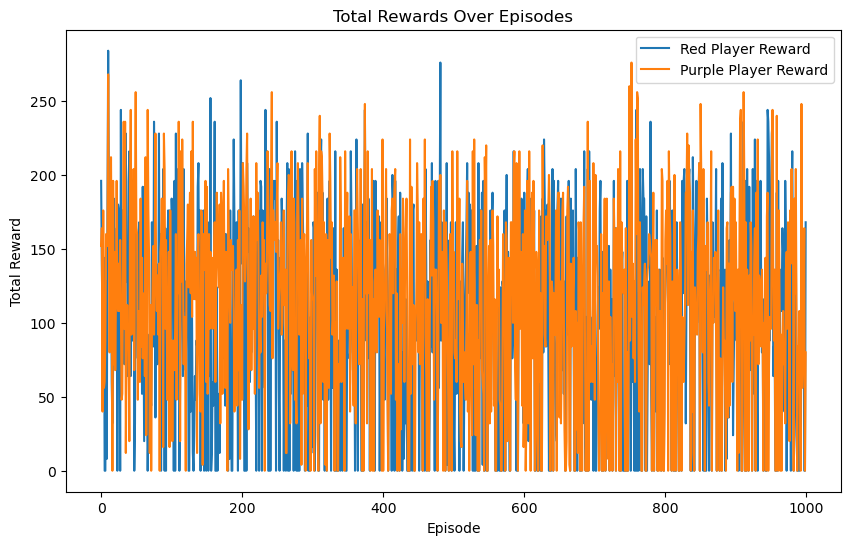

-0.016783744783744767
-0.027675819675819592


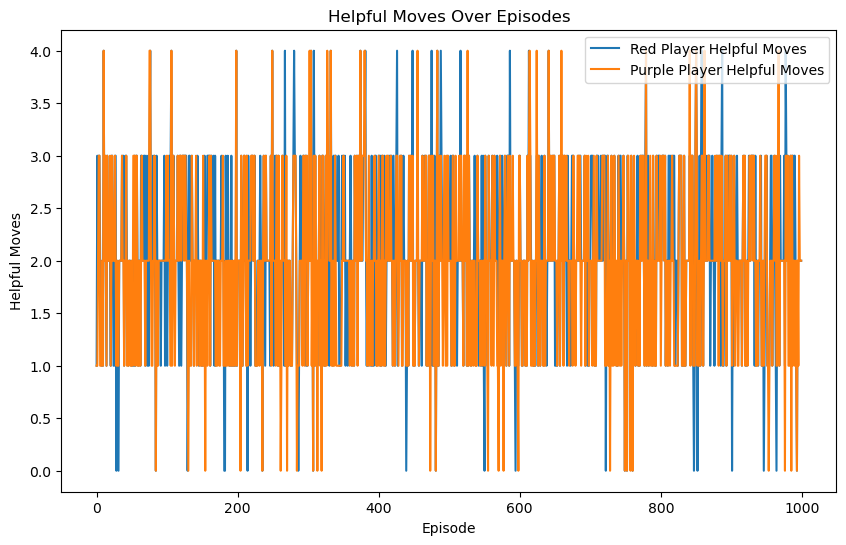

In [124]:
plt.figure(figsize=(10, 6))
plt.plot(final_rewards_red, label="Red Player Reward")
plt.plot(final_rewards_purple, label="Purple Player Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Rewards Over Episodes")
plt.legend()
plt.show()
# Generate x values (indices of the original values)
x = np.arange(len(final_rewards_red))

# Calculate the line of best fit
coefficients = np.polyfit(x, final_rewards_red, 1)
line_of_best_fit = np.poly1d(coefficients)

slope = coefficients[0]
print(slope)

# Calculate the line of best fit
coefficients = np.polyfit(x, final_rewards_purple, 1)
line_of_best_fit = np.poly1d(coefficients)

slope = coefficients[0]
print(slope)

# Example: Plot helpful moves
plt.figure(figsize=(10, 6))
plt.plot(helpful_moves_red, label="Red Player Helpful Moves")
plt.plot(helpful_moves_purple, label="Purple Player Helpful Moves")
plt.xlabel("Episode")
plt.ylabel("Helpful Moves")
plt.title("Helpful Moves Over Episodes")
plt.legend()
plt.show()


In [81]:
def OLS(values):
    # Generate x values (indices of the original values)
    x = np.arange(len(values))

    # Add a constant to the independent variables matrix for the intercept
    X = sm.add_constant(x)

    # Fit the linear regression model
    model = sm.OLS(values, X)
    results = model.fit()

    # Print the summary
    print(results.summary())

    # Extract slope and its confidence interval
    slope = results.params[1]
    slope_ci = results.conf_int()[1]
    print(f"Slope: {slope}, 95% Confidence Interval: {slope_ci}")

    # Plot the original values
    plt.plot(values, 'o', label='Original values')

    # Plot the line of best fit
    plt.plot(x, results.predict(X), '-', label='Line of Best Fit')

    # Add labels, title, and legend
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Trend of Values with Line of Best Fit')
    plt.legend()
    plt.grid(True)
    plt.show()


In [82]:
total_reward = np.array(final_rewards_red)+np.array(final_rewards_purple)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7212
Date:                Tue, 10 Dec 2024   Prob (F-statistic):              0.396
Time:                        12:36:06   Log-Likelihood:                -2986.6
No. Observations:                 500   AIC:                             5977.
Df Residuals:                     498   BIC:                             5986.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        234.9558      8.505     27.624      0.0

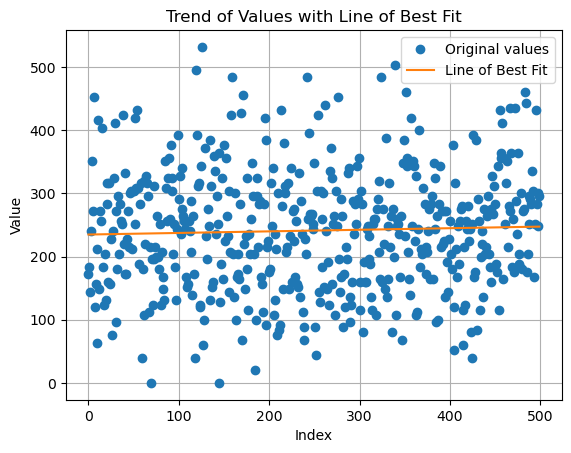

In [83]:
OLS(total_reward)

In [84]:
#Seeing learning!

In [85]:
all_helping = np.array(helpful_moves_red)+np.array(helpful_moves_purple)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.059
Date:                Tue, 10 Dec 2024   Prob (F-statistic):              0.304
Time:                        12:36:13   Log-Likelihood:                -917.08
No. Observations:                 500   AIC:                             1838.
Df Residuals:                     498   BIC:                             1847.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9072      0.136     28.825      0.0

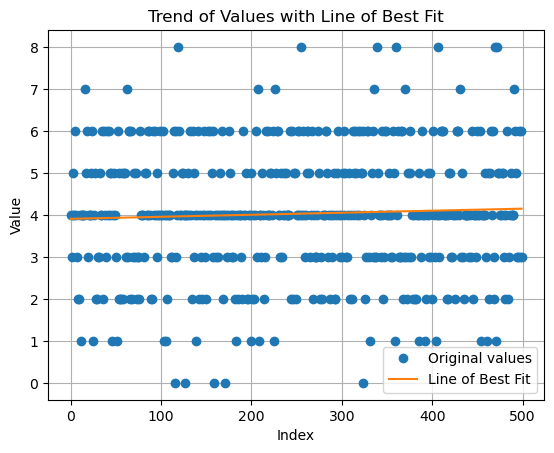

In [86]:
OLS(all_helping)

# walking through step by step 

### setup

In [96]:
agent1 = QLearningAgent(learning_rate=0.15, discount_factor=0.99, epsilon=0.2)
agent2 = QLearningAgent(learning_rate=0.15, discount_factor=0.99, epsilon=0.2)

final_rewards_red = []  # To store the final rewards of the 'red' player
final_rewards_purple = []  # To store the final rewards of the 'purple' player
helpful_moves_red = []  # To track the number of helpful moves for the 'red' player
helpful_moves_purple = []  # To track the number of helpful moves for the 'purple' player

#state = env.reset()  # Reset the environment for a new episode
state = farmgame.configure_game(layer="Items00",resourceCond="even",costCond="low",visibilityCond="full",redFirst=True)

#done = False

In [97]:
state.redplayer

{'loc': {'x': 2, 'y': 15},
 'name': 'red',
 'type': 'player',
 'color': 'red',
 'capacity': 4,
 'contents': [],
 'backpack': {'name': 'red',
  'type': 'backpack',
  'capacity': 4,
  'contents': []},
 'score': 0,
 'energy': 100,
 'bonuspoints': 0,
 'has_helped': False}

In [98]:
state.purpleplayer

{'loc': {'x': 3, 'y': 16},
 'name': 'purple',
 'type': 'player',
 'color': 'purple',
 'capacity': 4,
 'contents': [],
 'backpack': {'name': 'purple',
  'type': 'backpack',
  'capacity': 4,
  'contents': []},
 'score': 0,
 'energy': 100,
 'bonuspoints': 0,
 'has_helped': False}

In [99]:
state = farmgame.configure_game(layer="Items00",resourceCond="even",costCond="low",visibilityCond="full",redFirst=True)
agent1.update(state)
agent2.update(state)

red_helpful_count = 0  # Counter for red's helpful moves
purple_helpful_count = 0  # Counter for purple's helpful moves


### Red takes a step

In [110]:
action1 = agent1.choose_action()
transition = farmgame.Transition(state, action1)
if transition.is_helping():
    red_helpful_count += 1

next_state = state.take_action(action1, inplace=True)
#print("Step taken to " + str(agent1.get_state_representation(agent1.current_state)))
reward1, done = next_state.reward("red")  # Get reward for the red player
agent1.update_q_value(action1, reward1, next_state)
state = next_state

In [111]:
state.redplayer

{'loc': {'x': 15, 'y': 7},
 'name': 'red',
 'type': 'player',
 'color': 'red',
 'capacity': 4,
 'contents': [],
 'backpack': {'name': 'red',
  'type': 'backpack',
  'capacity': 4,
  'contents': []},
 'score': 1,
 'energy': 68,
 'bonuspoints': 0,
 'has_helped': False}

In [106]:
## so red slept, same spot

In [107]:
# Agent 2's turn (Purple)
action2 = agent2.choose_action()
transition = farmgame.Transition(state, action2)
if transition.is_helping():
    purple_helpful_count += 1

next_state = state.take_action(action2, inplace=True)
reward2, done = next_state.reward("purple")  # Get reward for the purple player
agent2.update_q_value(action2, reward2, next_state)
state = next_state

In [108]:
state.purpleplayer

{'loc': {'x': 8, 'y': 7},
 'name': 'purple',
 'type': 'player',
 'color': 'purple',
 'capacity': 4,
 'contents': [],
 'backpack': {'name': 'purple',
  'type': 'backpack',
  'capacity': 4,
  'contents': [<farmgame.Action at 0x15112f9d0>]},
 'score': 0,
 'energy': 81,
 'bonuspoints': 0,
 'has_helped': True}

In [109]:
# We see purple moved to turnip, but why does it have same backpack capacity
#We see it has backpack content now. So it should be picked up and capacity has not been updated



In [24]:
action1 = agent1.choose_action()
transition = farmgame.Transition(state, action1)
if transition.is_helping():
    red_helpful_count += 1

next_state = state.take_action(action1, inplace=True)
#print("Step taken to " + str(agent1.get_state_representation(agent1.current_state)))
reward1, done = next_state.reward("red")  # Get reward for the red player
agent1.update_q_value(action1, reward1, next_state)
state = next_state
state.redplayer

Exploiting: Chose action Eggplant00(12,14) with Q-value 0.0
Updated Q-value for state-action pair ({'x': 12, 'y': 14}, (<ActionType.veggie: 'veggie'>, 12, 14)): 0.0
Reward: 0, TD Target: 0.0, TD Error: 0.0


{'loc': {'x': 12, 'y': 14},
 'name': 'red',
 'type': 'player',
 'color': 'red',
 'capacity': 4,
 'contents': [<farmgame.Action at 0x281f92a10>,
 'backpack': {'name': 'red',
  'type': 'backpack',
  'capacity': 4,
  'contents': [<farmgame.Action at 0x281f92a10>,
   <farmgame.Action at 0x281f92ad0>]},
 'score': 0,
 'energy': 87,
 'bonuspoints': 0,
 'has_helped': True}

In [25]:
# Agent 2's turn (Purple)
action2 = agent2.choose_action()
transition = farmgame.Transition(state, action2)
if transition.is_helping():
    purple_helpful_count += 1

next_state = state.take_action(action2, inplace=True)
reward2, done = next_state.reward("purple")  # Get reward for the purple player
agent2.update_q_value(action2, reward2, next_state)
state = next_state
state.purpleplayer

Exploiting: Chose action Turnip01(13,13) with Q-value 0.0
Updated Q-value for state-action pair ({'x': 13, 'y': 13}, (<ActionType.veggie: 'veggie'>, 13, 13)): 0.0
Reward: 0, TD Target: 0.0, TD Error: 0.0


{'loc': {'x': 13, 'y': 13},
 'name': 'purple',
 'type': 'player',
 'color': 'purple',
 'capacity': 4,
 'contents': [],
 'backpack': {'name': 'purple',
  'type': 'backpack',
  'capacity': 4,
  'contents': [<farmgame.Action at 0x281f93210>]},
 'score': 0,
 'energy': 82,
 'bonuspoints': 0,
 'has_helped': False}

In [26]:
state.all_objects_picked_up('purple')

AttributeError: 'Farm' object has no attribute 'all_objects_picked_up'

In [ ]:
#now it should have two things in the backpack? Only 1?
#why is the location the same if it went to eggplant?
